# Project: Thermal simulation and control of buildings

### imports


In [127]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Materials, heat capacity, geometry

#### Walls
- We model in total 2 2-layered walls where the exterior layer followed by the interiror insulation layer

In [128]:
concrete = {'Conductivity': 1.700,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.15,
            "alpha": 0.60}

insulation = {'Conductivity': 0.040,
              'Density': 80,
              'Specific heat': 800,
              'Width': 0.10}

wall = pd.DataFrame.from_dict({'Layer_1': concrete,
                               'Layer_2': insulation},
                              orient='index')


##### Wall surface
- We assume that the wall of the building has the dimensions of 3x3 meters, this would result in a surface area of $9m^2$
- Since both walls have a window we calculate the actual surface area of the wall without windows and subtract the window surface area.
- This will give us the the real area of the wall of $6.9m^2$

In [129]:
S_wall = (3 * 3) - (1.4 * 1.5)
S_wall

6.9

Solar radiation absorption $\alpha$
- https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html

In [130]:
wall_radiation_absorption_alpha = 0.65

#### Room Air

In [131]:
air = {'Density': 1.2, 'Specific heat': 1000, 'h_in': 5., 'h_out': 10}
air = pd.DataFrame(air, index=['Air'])

#### Windows
- Window Type: Triple-Glazed, Medium-solar-gain Low-E Glass
- SGHC value 0.24 https://efficientwindows.org/gtypes-3lowe/
- U-factor 0.15
- the size is 140 x 150 cm
- The surface is 2.10 m²

In [132]:
A_window = 1.4 * 1.5    # 2.10 m²
u_factor = 0.15         # Used for convection
SGHC = 0.24             # Used for transmitted solar radiation thorugh the window
V_air = 3 * 3 * 3       # air volume

## Assembling the Model

### Matrices

#### A-Matrix

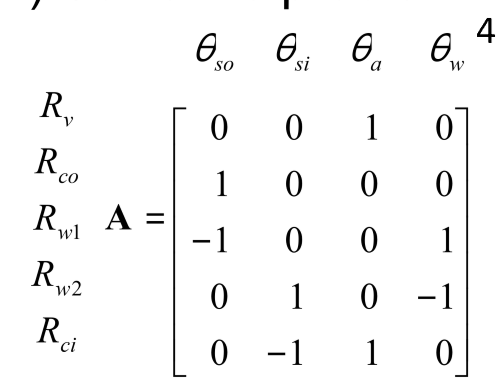

In [133]:
import numpy as np

A = np.array([
    [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # q0 :  T0  -> theta0   (R0)
    [-1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # q1 :  theta0 -> theta1 (R1)
    [ 0, -1, +1,  0,  0,  0,  0,  0,  0,  0,  0],  # q2 :  theta1 -> theta2 (R2)
    [ 0,  0, -1, +1,  0,  0,  0,  0,  0,  0,  0],  # q3 :  theta2 -> theta3 (R3)
    [ 0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0],  # q4 :  theta3 -> theta4 (R4)
    [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0, +1],  # q5 :  theta4 -> theta_iair (R10)

    [ 0,  0,  0,  0,  0, +1,  0,  0,  0,  0,  0],  # q6 :  T0 -> theta5 (R5)
    [ 0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0],  # q7 :  theta5 -> theta6 (R6)
    [ 0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0],  # q8 :  theta6 -> theta7 (R7)
    [ 0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0],  # q9 :  theta7 -> theta8 (R8)
    [ 0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0],  # q10:  theta8 -> theta9 (R9)
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1],  # q11:  theta9 -> theta_iair (R11)  <-- changed

    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1],  # q12:  T0_i -> theta_iair (R12)
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1],  # q13:  T0_j -> theta_iair (R13)
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1],  # q14:  T_set -> theta_iair (R14)
], dtype=int)

print(A.shape)  # (15, 11)


(15, 11)


#### C-Matrix

In [134]:
C_air = air['Density'] * air['Specific heat'] * V_air

In [135]:
C_wall_1 = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall
C_wall_2 = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall

In [136]:
C = np.zeros(11)

In [137]:
C[1] = C_wall_1.Layer_1.item()
C[3] = C_wall_1.Layer_2.item()
C[6] = C_wall_2.Layer_1.item()
C[8] = C_wall_2.Layer_2.item()
C[10] = C_air.item() # 0

In [138]:
# C matrix diagonals must have the same ordering as the nodes

In [139]:
C = np.diag(C)

#### G-Matrix

In [140]:
G = np.zeros(A.shape[0])
G[0] = (S_wall * air["h_in"]).item()
G[1] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_1.item()
G[2] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_1.item()
G[3] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_2.item()
G[4] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_2.item()


G[5] = (S_wall * air["h_in"]).item()
G[6] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_1.item()
G[7] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_1.item()
G[8] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_2.item()
G[9] = ((S_wall * wall["Conductivity"]) / wall["Width"]).Layer_2.item()
G[10] = (S_wall * air["h_out"]).item()
G[11] = (S_wall * air["h_out"]).item()

G[12] = A_window * u_factor
G[13] = A_window * u_factor
G[14] = 0 # HVAC

In [141]:
G = np.diag(G)

### Testing

#### Steady State Test

In [142]:
b = np.zeros(15)  # temperature sources
f = np.zeros(11)  # flow sources

In [143]:
b[[0, 6, 12, 13]] = 1

In [144]:
θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', θ_steady_To, '°C')
print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


In [145]:
f[-1] = 1
θ_steady_Qh = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('When Qh = 1W, the temperatures in steady-state are:', θ_steady_Qh, '°C')
print(f'The indoor temperature is: {θ_steady_Qh[-1]:.3f} °C')

When Qh = 1W, the temperatures in steady-state are: [1.01138314 1.01640511 1.02142708 1.16371628 1.30600548 1.00520878
 1.01041757 1.15799981 1.30558204 1.31148533 1.31738862] °C
The indoor temperature is: 1.317 °C


### inputs & outputs

Given our model we have in total 4 temperature sources where each is represented by its own branch:
 - 2 going through the 2 walls
 - 2 going through the walls respevtive windows

In [146]:
# Inputs
b = np.zeros(15)  # temperature sources
f = np.zeros(11)  # flow sources

b[[0, 6, 12, 13]] = 1

In [147]:
f[0] = 1 # Flow source: Absorbed solar radiation of 1st wall
f[5] = 1 # Flow source: Absorbed solar radiation of 2nd wall
#f[-1] = 1 # inner flow source (occupancy) + transmitted radiation through the windows + HVAC control

In [148]:
# Outputs
y = np.zeros(11)  # nodes
y[10] = 1 # node of interest: room inner air temperature

### State Space

In [149]:
from pd_dm4bem import tc2ss, read_epw, sol_rad_tilt_surf, inputs_in_time
from dm4bem import tc2ss, read_epw, sol_rad_tilt_surf

In [150]:
[As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)

#### Eigenvalue Analysis

In [151]:
eigenvalue, eigenvectors = np.linalg.eig(As)

##### Step size 
For the system to be stable we cannot exceed a integrarion stepsize of 3.08 seconds

In [152]:
λ = eigenvalue
max_Δt = min(-2 / λ)

np.set_printoptions(precision=1)
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
print(f'Max time step Δt = {max_Δt:.2f} s')

Time constants: 
 [  521.3  7134.3 26811.2 86809.5 53170.3] s 

2 x Time constants: 
 [  1042.7  14268.6  53622.4 173619.1 106340.5] s 

Max time step Δt = 1042.70 s


In [153]:
dt = 1000
print(f'Δt = {dt} s')

Δt = 1000 s


##### Settling time

The settling time is 96.46h so we need to simulate for this duration for the response to be steady state

In [154]:
# settling time
t_settle = 4 * max(-1 / λ)
print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')

Settling time: 347238.18 s = 96.46 h


##### step response

In [155]:
# number of time steps
n = int(np.ceil(t_settle / dt))
# time vector
t = np.arange(0, n * dt, dt)

In [160]:
n_temperature_soruces = 4
n_flow_sources = 2
u = np.vstack([np.vstack([np.ones([1, n])]*n_temperature_soruces), np.vstack([np.zeros([1, n])]*n_flow_sources)])

In [161]:
θ_exp = np.zeros([As.shape[0], t.shape[0]])

In [162]:
for k in range(t.shape[0] - 1):
    θ_exp[:, k + 1] = (np.eye(As.shape[0]) + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]

In [163]:
y_out = Cs @ θ_exp + Ds @u

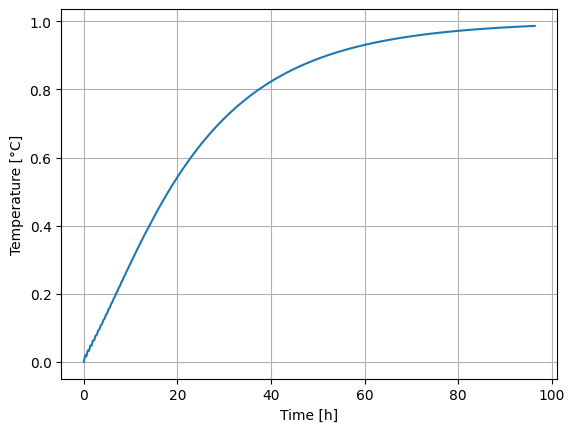

In [164]:
plt.plot(t/3600, y_out.T)
plt.xlabel("Time [h]"); plt.ylabel("Temperature [°C]"); plt.grid(True)

### Weather data

In [499]:
df, info = read_epw("weather_data/POL_Warsaw.123750_IWEC.epw")

In [500]:
df = df[["temp_air", "dir_n_rad", "dif_h_rad"]]
df.index = df.index.map(
    lambda t: t.replace(year=2000))
df.index = pd.to_datetime(df.index)


In [501]:
df = df.resample(f"{dt}s").interpolate("linear").loc["2000-01-01 01:00:00+01:00": "2000-01-30 01:00:00+01:00"]

In [502]:
df

,temp_air,dir_n_rad,dif_h_rad
2000-01-01 01:00:00+01:00,-3.2000,0.0,0.0
2000-01-01 01:00:30+01:00,-3.2050,0.0,0.0
2000-01-01 01:01:00+01:00,-3.2100,0.0,0.0
2000-01-01 01:01:30+01:00,-3.2150,0.0,0.0
2000-01-01 01:02:00+01:00,-3.2200,0.0,0.0
...,...,...,...
2000-01-30 00:58:00+01:00,0.9900,0.0,0.0
2000-01-30 00:58:30+01:00,0.9925,0.0,0.0
2000-01-30 00:59:00+01:00,0.9950,0.0,0.0
2000-01-30 00:59:30+01:00,0.9975,0.0,0.0


#### Wall 1 + window orientation

In [503]:
wall_1_surface_orientation = {'slope': 90,    
                       'azimuth': 90,
                       'latitude': 52.23}

#### Wall 2 + window orientation

In [504]:
wall_2_surface_orientation = {'slope': 90, 
                       'azimuth': 180,    
                       'latitude': 52.23}

In [505]:
weathe4wall1 = sol_rad_tilt_surf(df, wall_2_surface_orientation, albedo=0.4)
weathe4wall2 = sol_rad_tilt_surf(df, wall_1_surface_orientation, albedo=0.4)

weathe4window1 = sol_rad_tilt_surf(df, wall_1_surface_orientation, albedo=0.25)
weathe4window2 = sol_rad_tilt_surf(df, wall_2_surface_orientation, albedo=0.25)

In [506]:
E_tot_1_wall = weathe4wall1.sum(1)
E_tot_2_wall = weathe4wall2.sum(1)

In [507]:
E_tot_1_window = weathe4window1.sum(1)
E_tot_2_window = weathe4window2.sum(1)

Absorbt solar radiation in the wall

In [508]:
Q_abs_1 = E_tot_1_wall * wall_radiation_absorption_alpha * S_wall
Q_abs_2 = E_tot_2_wall * wall_radiation_absorption_alpha * S_wall

Transmitted solar radiation of the windows

In [523]:
Q_trans1 = E_tot_1_window * SGHC * A_window
Q_trans2 = E_tot_2_window * SGHC * A_window

In [524]:
met = df[['temp_air']]

In [525]:
(Q_trans1+Q_trans2)

2000-01-01 01:00:00+01:00    0.0
2000-01-01 01:00:30+01:00    0.0
2000-01-01 01:01:00+01:00    0.0
2000-01-01 01:01:30+01:00    0.0
2000-01-01 01:02:00+01:00    0.0
                            ... 
2000-01-30 00:58:00+01:00    0.0
2000-01-30 00:58:30+01:00    0.0
2000-01-30 00:59:00+01:00    0.0
2000-01-30 00:59:30+01:00    0.0
2000-01-30 01:00:00+01:00    0.0
Freq: 30s, Length: 83521, dtype: float64

In [526]:
f

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [527]:
solar_rad_wall = np.vstack([Q_abs_1.values, Q_abs_2.values])
air_temp = np.vstack([met.values.T]*4)
u = np.vstack([air_temp, solar_rad_wall])

In [528]:
u.shape

(6, 83521)

In [529]:
Bs.shape

(5, 6)

In [530]:
θ_exp = np.zeros([As.shape[0], met.shape[0]])

In [531]:
for k in range(met.shape[0] - 1):
    θ_exp[:, k + 1] = (np.eye(As.shape[0]) + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]

In [532]:
y_out = Cs @ θ_exp + Ds @ u

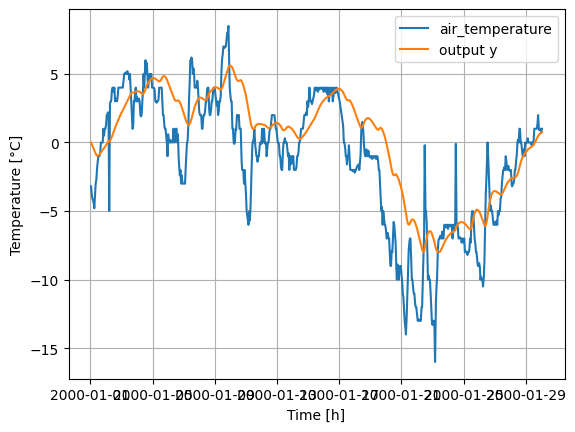

In [533]:
plt.figure()
plt.plot(met, label="air_temperature")
plt.plot(met.index, y_out.T, label="output y")
plt.legend()
plt.xlabel("Time [h]"); plt.ylabel("Temperature [°C]"); plt.grid(True)

### Adding A controller
- so far the model has been control free --> now add a controller to maintain the temperature on to a given setpoint

In [541]:
f[-1] = 1 # activate auxilary flow source for control

In [542]:
[As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)

In [543]:
As.shape, Bs.shape, Cs.shape, Ds.shape

((5, 5), (5, 7), (1, 5), (1, 7))

In [544]:
Cs.shape

(1, 5)

In [545]:
T_setpoint = 21.0
Kp = 1e2

solar_rad_wall = np.vstack([Q_abs_1.values, Q_abs_2.values])
air_temp = np.vstack([met.values.T]*4)
u = np.vstack([air_temp, solar_rad_wall])
u = np.vstack([u, np.zeros((1, met.shape[0]), dtype=float)])

hvac_idx = u.shape[0] - 1


θ_exp = np.zeros((As.shape[0], met.shape[0]), dtype=float)
y_out = np.zeros((1, met.shape[0]), dtype=float)

I = np.eye(As.shape[0])

In [546]:
dt = 30

In [547]:
for k in range(met.shape[0] - 1):
    T_in = float(θ_exp[:, k][-1])
    y_out[:, k] = T_in

    if T_in < T_setpoint:
        u[hvac_idx, k+1] = Kp * (T_setpoint - T_in)
    else:
        u[hvac_idx, k+1] = 0.0

    θ_exp[:, k + 1] = (np.eye(As.shape[0]) + dt * As) @ θ_exp[:, k] + dt * Bs @ u[:, k]

In [548]:
y_out = Cs @ θ_exp + Ds @ u

In [549]:
y_out.shape

(1, 83521)

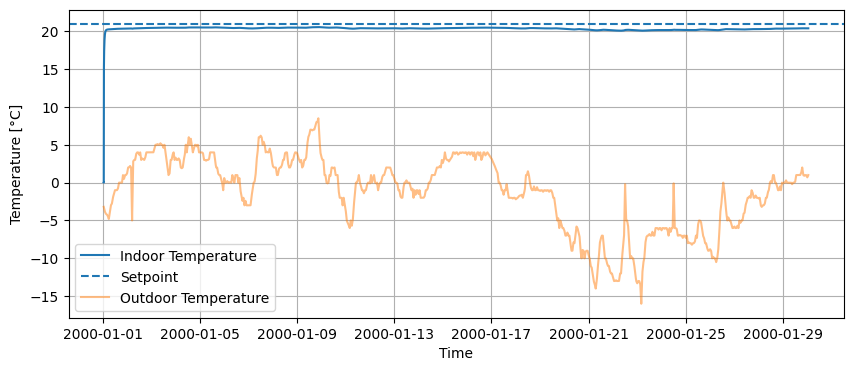

In [550]:
# --- plots ---
plt.figure(figsize=(10, 4))
plt.plot(met.index, y_out.T, label="Indoor Temperature")
plt.axhline(T_setpoint, linestyle='--', label="Setpoint")
plt.plot(met.index, met.values, label="Outdoor Temperature", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.show()


In [810]:
Ki, Kp, Kd = 1e-4,1e-5,1e-3

In [811]:
T_i = Kp / Ki
T_d = Kd / Kp
T_i, T_d
θ_exp = np.zeros((As.shape[0], met.shape[0]), dtype=float)
y_out = np.zeros((1, met.shape[0]), dtype=float)

In [ ]:
np.linspace(0, 1, 1000)[1:]

array([0.001001  , 0.002002  , 0.003003  , 0.004004  , 0.00500501,
       0.00600601, 0.00700701, 0.00800801, 0.00900901, 0.01001001,
       0.01101101, 0.01201201, 0.01301301, 0.01401401, 0.01501502,
       0.01601602, 0.01701702, 0.01801802, 0.01901902, 0.02002002,
       0.02102102, 0.02202202, 0.02302302, 0.02402402, 0.02502503,
       0.02602603, 0.02702703, 0.02802803, 0.02902903, 0.03003003,
       0.03103103, 0.03203203, 0.03303303, 0.03403403, 0.03503504,
       0.03603604, 0.03703704, 0.03803804, 0.03903904, 0.04004004,
       0.04104104, 0.04204204, 0.04304304, 0.04404404, 0.04504505,
       0.04604605, 0.04704705, 0.04804805, 0.04904905, 0.05005005,
       0.05105105, 0.05205205, 0.05305305, 0.05405405, 0.05505506,
       0.05605606, 0.05705706, 0.05805806, 0.05905906, 0.06006006,
       0.06106106, 0.06206206, 0.06306306, 0.06406406, 0.06506507,
       0.06606607, 0.06706707, 0.06806807, 0.06906907, 0.07007007,
       0.07107107, 0.07207207, 0.07307307, 0.07407407, 0.07507

In [ ]:
def control_test(As, Bs, Cs, Ds, u, Kp, dt, include_d_term=False):
    trajectories = []
    for config in np.linspace(0, 1, 1000)[1:]:
        θ_exp = np.zeros((As.shape[0], met.shape[0]), dtype=float)
        I_term = 0
        e_prev = 0
        Ki, Kp, Kd = config, Kp, 1e-3
        T_i = Kp / Ki
        T_d = Kd / Kp
        
        for k in range(met.shape[0] - 1):
            T_in = float(θ_exp[:, k][-1])
            
            e = T_setpoint - T_in
            
            I_term += (dt / T_i) * e
            if include_d_term:
                D_term  = (T_d / dt) * (e - e_prev)
            
            control_ut = Kp * (I_term + e + (D_term if include_d_term else 0))
            
            u[hvac_idx, k+1] = control_ut

            θ_exp[:, k + 1] = (np.eye(As.shape[0]) + dt * As) @ θ_exp[:, k] + dt * Bs @ u[:, k]
            e_prev = e
        
        trajectories.append((Cs @ θ_exp + Ds @ u).T)
    
    return np.hstack(trajectories)

In [833]:
control_test(As, Bs, Cs, Ds, u, 1e-3, 30, False)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 83521 is different from 7)

In [ ]:
I_term = 0
e_prev = 0
for k in range(met.shape[0] - 1):
    T_in = float(θ_exp[:, k][-1])
    
    e = T_setpoint - T_in

    I_term += (dt / T_i) * e
    D_term  = (T_d / dt) * (e - e_prev)
    
    control_ut = Kp * (I_term + D_term + e)
    #print(control_ut)
    
    u[hvac_idx, k+1] = control_ut
    

    θ_exp[:, k + 1] = (np.eye(As.shape[0]) + dt * As) @ θ_exp[:, k] + dt * Bs @ u[:, k]
    
    e_prev = e
 

0.06391000000000001
0.12621568088888893
0.1892265301107527
0.25224227161640134
0.31526257674688735
0.3782871320521754
0.44131563830475506
0.5043478097098115
0.5673833731396934
0.6304220674123985
0.6934636426115389
0.7565078594454075
0.8195544886428912
0.8826033103841127
0.9456541137638079
1.0087066962855495
1.0717608633850486
1.1348164279808561
1.1978732100508966
1.2609310362333381
1.3239897394504085
1.3870491585538307
1.450109137990639
1.5131695274882018
1.5762301817573456
1.6392909602125412
1.7023517267081678
1.765412349289936
1.82847269996059
1.8915326544590747
1.9545920920523896
2.0176508953394006
2.0807089500659233
2.1437661449504275
2.2068223715197526
2.269877523954262
2.3329314989418846
2.3959841955405428
2.4590355150484795
2.522085360882027
2.585133638460398
2.6481802550970834
2.7112251198974913
2.774268143662455
2.8373092387972787
2.9003483192260036
2.963385300310592
3.026420098774746
3.0894526326320944
3.1524828211185008
3.215510584628248
3.2785358446538835
3.3415585237295153

In [816]:
y_out = Cs @ θ_exp + Ds @ u

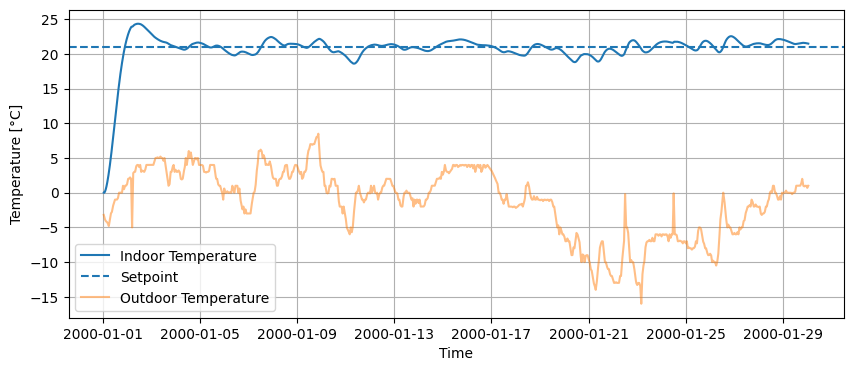

In [817]:
# --- plots ---
plt.figure(figsize=(10, 4))
plt.plot(met.index, y_out.T, label="Indoor Temperature")
plt.axhline(T_setpoint, linestyle='--', label="Setpoint")
plt.plot(met.index, met.values, label="Outdoor Temperature", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.show()
